In [1]:
import math 
import numpy as np
import tdmclient.notebook


## Import packages and function

import cv2
from ultralytics import YOLO

from CV_function import *
from path_object import *
from Markov_Filter import *

### Main loop

In [2]:
#Initialize robot
try:
    await tdmclient.notebook.stop()
except:
    pass
await tdmclient.notebook.start()

In [3]:
#Initialize Global path object
global_nav = Global_nav()

In [4]:
#function to sync variables between the notebook and the robot
@tdmclient.notebook.sync_var
def get_prox():
    global prox_horizontal
    return prox_horizontal



In [5]:
def local_navigation():
    global prox_horizontal, motor_left_target, motor_right_target, button_center, state
    set_var(leds_top = [32, 0, 0])
    while max(get_prox())>100:
        weight_left = [25,  15, -20, -15, -25]
        weight_right = [-25, -15, -15,  15,  25]
    
        # Scale factors for sensors and constant factor
        sensor_scale = 500
        constant_scale = 20
    
        mem_sensor = [0,0,0,0,0]
        prox_horizontal = get_prox()
        
        for i in range(5):
            # Get and scale inputs
            mem_sensor[i] = prox_horizontal[i] // sensor_scale
    
        y = [100,100]   
        
        for i in range(len(mem_sensor)):   
            # Compute outputs of neurons and set motor powers
            y[0] = y[0] + mem_sensor[i] * weight_left[i]
            y[1] = y[1] + mem_sensor[i] * weight_right[i]
    
        # Set motor powers
        set_var(motor_left_target = min(y[0],150))
        set_var(motor_right_target = min(y[1],150))
        time.sleep(0.2)
    set_var(leds_top = [0, 0, 32])

    return

In [6]:


@tdmclient.notebook.sync_var
# drive straight with "speed" (motor speed)
def motors_drive(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

# drive "dist" [cm]
def drive(dist=10):
    motors_drive(150,150) #test with lower speed value
    for i in range(10):
        time.sleep((dist/(2*3))/10) #motor speed = 50 equals 2.5cm/s -> calculates how many s you have to drive to cover a distance "dist" [cm]
        if max(get_prox()) > 100:
            print("obstacle detected")
            local_navigation()
            break
    motors_drive(0,0)


@tdmclient.notebook.sync_var 
# turn in a circle with "speed" (motor speed)
def motors_turn(speed=100):
    global motor_left_target, motor_right_target
    motor_left_target = -speed
    motor_right_target = speed
    
@tdmclient.notebook.sync_var 
def motors_turn_right(speed=100):
    global motor_left_target, motor_right_target
    motor_left_target = speed
    motor_right_target = -speed

# turn "angle" [degrees] anticlockwise
def turn_degrees(angle):
    if angle < 0:
        motors_turn()
        time.sleep(abs(angle)*9/360) # 18s for 360° turn with motor speed = 100
        motors_turn(speed=0)
    else:
        motors_turn_right()
        time.sleep(abs(angle)*9/360)
        motors_turn_right(speed=0)

# turn "angle" (2. row of Astar_moves) then drive "dist" (1.row of Astar_moves)
def follow_path(dist,angle):
    turn_degrees(angle)
    drive(dist)
    
#used to initialize the follow robot command
def follow_path_init(path, current_angle,scale_factor):
    Ang = get_angle(path[0],path[1])
    Ang = Ang  - current_angle
    if abs(Ang) > 180:
                    if Ang > 0:
                        Ang = Ang-360
                    else:
                        Ang = Ang+360
    dist = get_distance(path[0],path[1])
    current_angle = Ang + current_angle
    follow_path(dist*scale_factor,-Ang)
    return current_angle



In [16]:
#sorted_object_last = [['robot', [0.1, 0.1, 0.12, 0.24], 0.912], ['mars',  [0.95, 0.95, 0.12, 0.24], 0.912], ['earth', [0.35, 0.89, 0.09, 0.15], 0.905]]
#sorted_object = [['robot', [0.1, 0.1, 0.12, 0.24], 0.912], ['mars',  [0.95, 0.95, 0.12, 0.24], 0.912], ['earth', [0.35, 0.89, 0.09, 0.15], 0.905]]

map_max_x = 100
map_max_y = 75
#initialize markov filter map 
initialize_maps(map_max_x,map_max_y)


#Set current angle to 0
current_angle = 0
#robot LED in driving mode
set_var(leds_top = [0, 0, 32])

i = 0
#Initialize camera
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID') 
output_ = cv2.VideoWriter('output.avi', fourcc, frames_per_second, (frame_height, frame_width)) 
while cap.isOpened():
    
    
    #image localization
    success, frame = cap.read()
    if  success:
        ## Computer vision detection
        array_box_dim_tot, annotated_frame = detection(frame)
        
        sorted_object = sorted(array_box_dim_tot, key=lambda x: order.get(x[0]))
        #break when q is pressed
        key = cv2.waitKey(1) & 0xFF 
        if key == ord('c'):  
            break  
    else:
        print("Unable to load the camera pic")
        break

    #fixing output from camera, use last output if no object is detected
    sorted_object = fix_output(sorted_object,sorted_object_last)
    

    if sorted_object == False: 
        start = opti_path[1] 
        opti_path = opti_path[1:]
        if len(opti_path) == 1:
            print("Reached goal")
            set_var(leds_top = [0, 32, 0])
            break
        current_angle = follow_path_init(opti_path,current_angle,scale_factor)
        last_robot_pos = list(start)
        annotated_frame = frame
        cv2.imshow("frame", annotated_frame)
        continue

    #save last output
    sorted_object_last = sorted_object

    #change format of pic output 
    start, goal, earth, robot_radius, earth_radius, black_holes_centers, black_holes_radiuss,scale_factor = global_nav.convert_OPENCV_tovalues(sorted_object)
    #if distance between robot and mars is less than 5 stop 
    if get_distance(start,goal) < 4:
        print("Reached goal")
        set_var(leds_top = [0, 32, 0])
        break
    
    #create map for gloabl navigation
    occ, _,_=  global_nav.create_map( goal = goal ,black_holes_centers = black_holes_centers,black_holes_radiuss=black_holes_radiuss)

    #use markov filter to update position 
    if i>0:
        print(np.linalg.norm(np.array(markov(opti_path[1][0],opti_path[1][1],start[0],start[1],sorted_object[0][2],i==0))-np.array(start)))
        if np.linalg.norm(np.array(markov(opti_path[1][0],opti_path[1][1],start[0],start[1],sorted_object[0][2],i==0))-np.array(start)) > 2: 
            pass
        elif sorted_object[0][2] > 0:
            start = markov(opti_path[1][0],opti_path[1][1],start[0],start[1],sorted_object[0][2],i==0)

    #return path. Use the opti_path! 
    opti_path, path, closed, open = global_nav.get_path_straight(start=start,goal=goal)
    #convert optipath to format used by camera
    scaled_coords = convert_coordinates_2d_list(opti_path)

    #annotate frame
    if i>0:
        annotation(annotated_frame, scaled_coords)
    cv2.imshow("frame", annotated_frame)
    output_.write(annotated_frame)
    
    #update current angle. Take the average of the calculated from image and robot motion
    if i != 0: 
        if list(start) != last_robot_pos:
            current_angle = update_angle(last_robot_pos,start,current_angle)


    #follow first two points in path
    current_angle = follow_path_init(opti_path,current_angle,scale_factor)

    #save last robot position
    last_robot_pos = list(start)

    i+=1
  
cv2.startWindowThread()
cap.release()
output_.release()
cv2.destroyAllWindows()

0.0
0.0
0.0
17.11724276862369
0.0
0.0
25.0
1.4142135623730951
0.0
0.0
12.529964086141668
obstacle detected
0.0
obstacle detected
0.0
obstacle detected
0.0
10.295630140987
Reached goal


In [ ]:
sorted_object[0][2]

0.919

In [ ]:
opti_path

[[72.0, 29.0], [77.0, 25.0]]

In [ ]:
opti_path[1][1],opti_path[1][0],start[0],start[1],sorted_object[0][2]

(25.0, 77.0, 77, 25, 0.919)

In [ ]:
opti_path[1][1],opti_path[1][0],start[0],start[1],sorted_object[0][2]

(25.0, 77.0, 77, 25, 0.919)

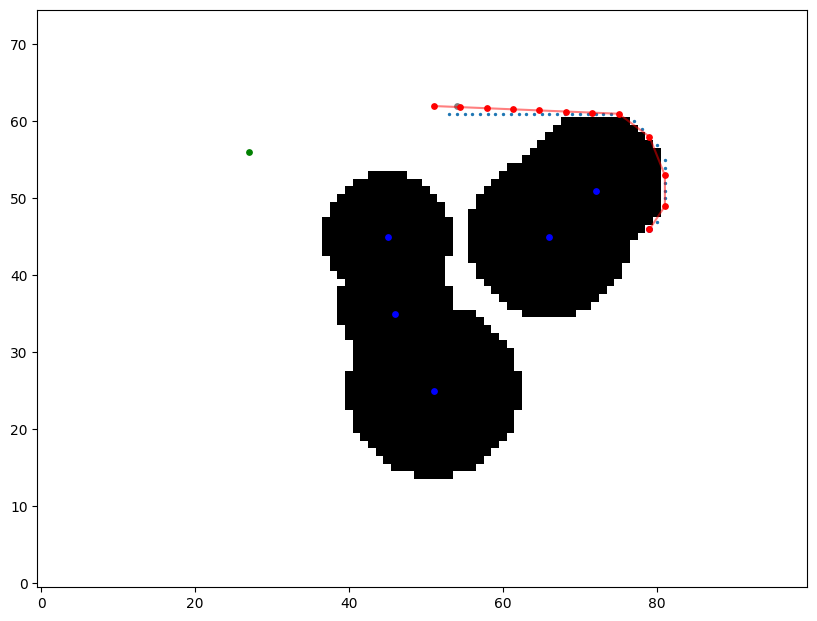

In [11]:
plt.figure(figsize=(10,7.5))
plt.imshow(occ.transpose(), cmap='Greys', origin='lower')
plt.scatter([x[0] for x in black_holes_centers], [x[1] for x in black_holes_centers], c='b',s=15)
plt.scatter(start[0],start[1], c='grey',s=15)
plt.scatter(goal[0],goal[1], c='purple',s=15)
plt.scatter(earth[0],earth[1], c='green',s=15)
plt.scatter([x[0] for x in path], [x[1] for x in path],s=2)

# plot 
plt.scatter([x[0] for x in opti_path], [x[1] for x in opti_path], c='r',s=15)
plt.plot([x[0] for x in opti_path], [x[1] for x in opti_path], c='r', alpha=0.5)


In [ ]:
set_var(motor_left_target = 0)
set_var(motor_right_target = 0)